In [1]:
"""
Промоделировать момент включения (релаксационные колебания) следующего иттербиевого
лазера:
a.
Коэффициенты отражения решёток: R1 = 100%, R2 = 50%.
b.
Мощность накачки 1.5 Вт
c.
Длина волны сигнала 1064 нм накачки 960 нм
d.
Распределением инверсии и мощностей излучения по длине световода
пренебречь.
e.
Длина активного волокна 3 м.
Найти зависимость характера релаксационных колебаний от параметров
резонатора.
"""

'\nПромоделировать момент включения (релаксационные колебания) следующего иттербиевого\nлазера:\na.\nКоэффициенты отражения решёток: R1 = 100%, R2 = 50%.\nb.\nМощность накачки 1.5 Вт\nc.\nДлина волны сигнала 1064 нм накачки 960 нм\nd.\nРаспределением инверсии и мощностей излучения по длине световода\nпренебречь.\ne.\nДлина активного волокна 3 м.\nНайти зависимость характера релаксационных колебаний от параметров\nрезонатора.\n'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
from numpy import pi
from scipy.integrate import solve_ivp
from scipy.integrate import solve_bvp
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [3]:
R1 = 1
R2 = 0.5

Pp = 1.5 #Wt
# Pp = 0 #Wt
lmbda_p = 960 #nm
lmbda_s = 1064 #nm
L = 3 #m

d = 10e-6
D = 125e-6
Aeffs = pi * d**2 / 4
Aeffp = 2 * pi * D**2 / 4 
c = 3e8 / 1.44
N = 4000 * 6.62e22 
tau = 1.54e-3
h = 6.63e-34
# n = 1.44



In [4]:
sigma = pandas.read_csv('Yb_cross_sections.csv', sep=';').to_numpy()
s_12_p = np.interp(lmbda_p, sigma[:, 0], sigma[:, 2])
s_21_p = np.interp(lmbda_p, sigma[:, 0], sigma[:, 1])
s_12_s = np.interp(lmbda_s, sigma[:, 0], sigma[:, 2])
s_21_s = np.interp(lmbda_s, sigma[:, 0], sigma[:, 1])

print(f' s_12_p = {s_12_p} s_21_p = {s_21_p}  s_12_s = {s_12_s} s_21_s = {s_21_s} ')

 s_12_p = 2.6e-25 s_21_p = 1.4e-25  s_12_s = 1.6000000000000001e-27 s_21_s = 1.3e-25 


In [5]:
def runge_kutta(f, y0, hh, left_x, right_x):#not a universal method
    x = np.arange(left_x, right_x+hh, hh)
    y = np.zeros((len(x), len(y0)))
    print(f'step = {hh}, left_x = {left_x} right_ x = {right_x}')
    y[0] = y0
    # print(f'y = {y}')
    for i in range(1, len(x)):

        k1 = np.array(f(x[i-1], y[i-1]))
        # print(f'k1 = {(k1)}, y[i-1]  = {y[i-1]} ')
        k2 = np.array(f(x[i-1] + hh/2, y[i-1] + hh/2*k1))
        # print(f'k2 = {k2}, y[i-1] + hh/2*k1 = {y[i-1] + hh/2*k1} ')
        k3 = np.array(f(x[i-1] + hh/2, y[i-1] + hh/2*k2))
        # print(f'k3 = {k3}, y[i-1] + hh/2*k2) = {y[i-1] + hh/2*k2}')
        k4 = np.array(f(x[i-1]+hh, y[i-1]+ hh * k3))
        # print(f'k4 = {k4},  y[i-1]+ hh * k3 = { y[i-1]+ hh * k3}')

        delta = hh/6 * (k1 + 2 * k2 + 2 * k3 + k4 )
        print(f'delta = {delta}')
        y[i] = y[i-1] + delta
        
    
    return x, y




In [6]:
def Yb( t, lmbda_p, lmbda_s,  s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c,  h, Aeffp, Aeffs,  Pp, N, L, R1, R2):
    
    # print("t:", t[0], t[-1], len(t))
    s_p = s_12_p + s_21_p
    s_s = s_12_s + s_21_s
    
    tau_c = - 2 * L / (c * np.log(R1*R2))
    # tau_c = tau  * 1.5
    # tau = 0.8 * tau_c
    print(f'tau_c = {tau_c * 10**9} нс')
  
    a_s = 1 / (c * tau_c)
    # print(f'a_s = {a_s}')


    Ip = Pp /(( Aeffp * h * c**2 )/(lmbda_p * 1e-9)) #pump density
    # Ip = Pp / Aeffp / c / (3 * 6.63 / lmbda_p * 1e-17)
    # N2_0 = (s_12_s * N + a_s) /s_s # constant level of excitation
    # N2_0 = (s_12_s * N) /s_s
    N2_0 = 0

    # Is_0 = ( N2_0/(c * tau) - (s_12_p * N - s_p * N2_0)* Ip ) / (s_12_s * N - s_s * N2_0) #constant signal level
    # Is_0 = Ip * 10**(-3)
    Is_0 = 1e-6
    # Is_0 = 0

    

    # print(f'Ip = {Ip} ')
    # print(f'N2_0 = {N2_0},  Inv = {N2_0 / N} ')
    # print(f'Is_0 = {Is_0}, Ps_0 = {Is_0 * (( Aeffs * h * c**2 )/(lmbda_s * 1e-9))} ')

    def fun(t, n): #N = [N2, Ps] 
        
        # print(f'in fun: inv = n[0]/N = {n[0]/N}, n[1] = {n[1]} ')
        N2 = n[0] #higher level
        Is = n[1] #signal


        dN2 = c * Ip * (s_12_p * N - s_p * N2) + c * Is * (s_12_s * N - s_s * N2) - N2/tau
        # dN2 = c * Ip * (s_12_p * N - s_p * N2) + c * Is * (s_12_s * N - s_s * N2) - 0 #if no spontan
        dIs = - c * Is * (s_12_s * N - s_s * N2) - Is / tau_c
        # print(f'in fun: dN2 = {dN2}, dIs = {dIs}')

        return [dN2, dIs]
    
    n0 = [N2_0, Is_0]
    answer = solve_ivp(fun, [0, t[-1]], n0, dense_output=True, min_step = t[-1]/100000 , method = 'RK45')
    # plt.plot(t, answer.sol(t))
    return answer.sol(t)

    # x, y = runge_kutta(fun, n0, T/res, 0, T)
    # return x, y


tau_c = 41.54961717760215 нс


c:\Users\vika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  warn("The following arguments have no effect for a chosen solver: {}."


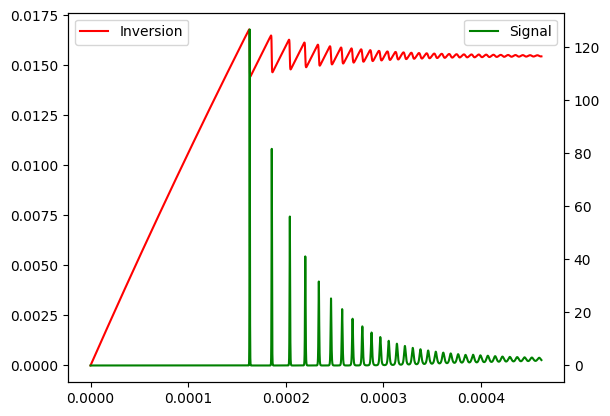

In [7]:

t = np.linspace(0, tau * 0.3, 10000)
sol = Yb(t, lmbda_p, lmbda_s,  s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c,  h, Aeffp, Aeffs,  Pp, N, L, R1, R2)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, sol[0]/N, 'r-', label = 'Inversion')
ax2.plot(t, sol[1] * (( Aeffs * h * c**2 )/(lmbda_s * 1e-9)), 'g-', label = 'Signal' )
ax1.legend(loc = 2)
ax2.legend(loc = 1)

0.13979444997054943


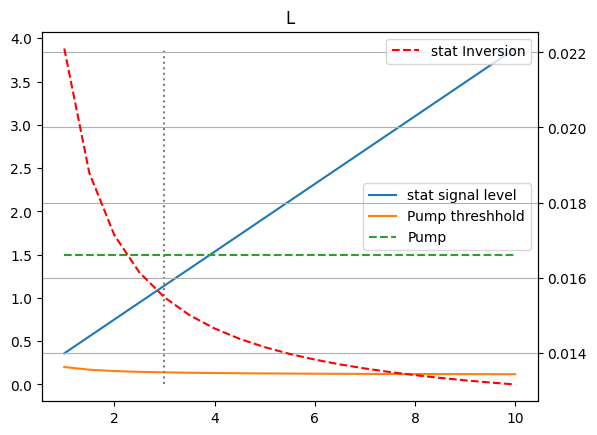

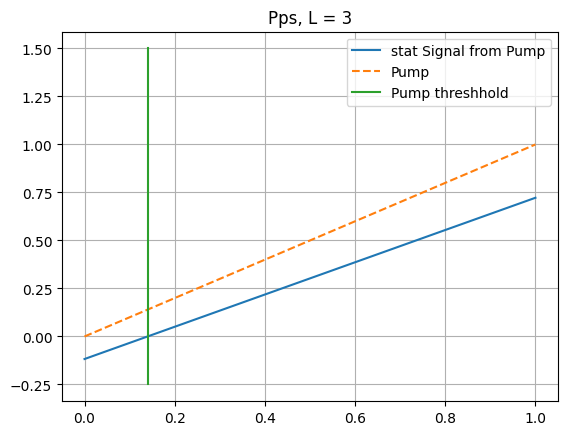

In [8]:
s_p = s_12_p + s_21_p
s_s = s_12_s + s_21_s

# Зависимость чего-то от длины волокна
def constant_levels(L, Pp):
    tau_c = - 2 * L / (c * np.log(R1*R2))
    a_s = 1 / (c * tau_c)

    Ip = Pp /(( Aeffp * h * c**2 )/(lmbda_p * 1e-9)) #pump density
    N2_0 = (s_12_s * N + a_s) /s_s # constant level of excitation

    N2_c = (s_12_s * N + a_s)/s_s
    Ip_c = (N2_c  / c / tau )/ (s_12_p * N - s_p * N2_c)
    Pp_c = Ip_c * (( Aeffp * h * c**2 )/(lmbda_p * 1e-9))

    a = -(s_12_p * N - s_p * N2_0 )/(s_12_s * N - s_s * N2_0)
    b = N2_0/(c * tau)/(s_12_s * N - s_s * N2_0)
    Is_0 = a * Ip  + b
    Ps_0 = Is_0 * (( Aeffs * h * c**2 )/(lmbda_s * 1e-9)) * 0.5

    return Ps_0, Pp_c, N2_0


Ls = np.arange(1, 10.5, .5)
lPs_0s = []
lPp_cs = []
lN2_0s = []
for l in Ls:
    lPs_0s.append(constant_levels(l, Pp)[0])
    lPp_cs.append(constant_levels(l, Pp)[1])
    lN2_0s.append(constant_levels(l, Pp)[2])

fig, ax = plt.subplots()
ax.plot(Ls, lPs_0s, label = 'stat signal level')
ax.plot(Ls, lPp_cs, label = 'Pump threshhold')
ax.plot(Ls, [Pp] * len(Ls), '--' , label = 'Pump' )
ax.plot([L, L], [0, lPs_0s[-1]], ':', color = 'gray')
ax1 = plt.twinx(ax)
ax1.plot(Ls, np.array(lN2_0s)/N,'r--', label = 'stat Inversion')
plt.title('L')
plt.grid()
ax.legend()
ax1.legend()
# plt.legend()


# Зависимость чего - то от мощности накачки
Pps = np.linspace(0, 1, 20)
pPs_0s = []
Pp_c = constant_levels(L, 0)[1]
for p in Pps:
    pPs_0s.append(constant_levels(L, p)[0])
print(Pp_c)
fig, ax = plt.subplots()
plt.plot(Pps, pPs_0s,  label = 'stat Signal from Pump' )
plt.plot(Pps, Pps, '--', label = 'Pump' )
plt.plot([Pp_c, Pp_c], [-0.25, 1.5], label = 'Pump threshhold')
plt.title(f'Pps, L = {L}')
plt.grid()
plt.legend()

# print(f'Ip = {Ip} ')
# print(f'N2_0 = {N2_0},  Inv = {N2_0 / N} ')
# print(f'Is_0 = {Is_0}, Ps_0 = {Is_0 * (( Aeffs * h * c**2 )/(lmbda_s * 1e-9))} ')

In [9]:
s_12_p/s_p

0.65

In [10]:
Ip = Pp /(( Aeffp * h * c**2 )/(lmbda_p * 1e-9)) #pump density
N2_s = s_12_p * Ip/(s_p * Ip + 1/(c*tau)) * N
N2_s/N

0.13480417555956345

581.7732424563845 -1.1054623320277151e+20
0.11552453009332421 0.01547318300940907


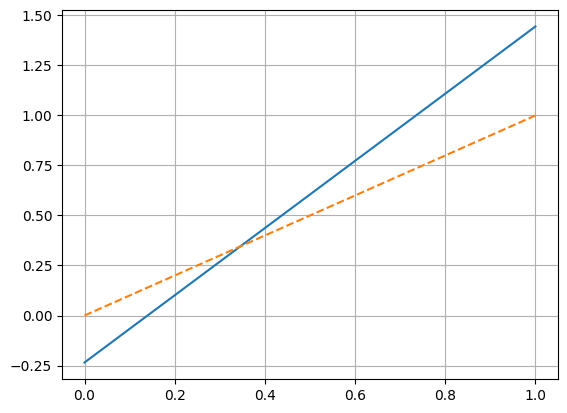

In [11]:
def ab(LL):
    tau_c = - 2 * LL / (c * np.log(R1*R2))
    a_s = 1 / (c * tau_c)
    
   
    N2_0 = (s_12_s * N + a_s) /s_s # constant level of excitation
    a = (s_12_p * N - s_p * N2_0)/a_s
    b = -(s_12_s * N + a_s)/(s_s * c * tau * a_s)

    a = -(s_12_p * N - s_p * N2_0 )/(s_12_s * N - s_s * N2_0)
    b = N2_0/(c * tau)/(s_12_s * N - s_s * N2_0)
    print(a, b)
    print(a_s, N2_0/N)
    return a, b
# stat signal level from pump
Pps = np.linspace(0, 1, 10)
Ip = Pps /(( Aeffp * h * c**2 )/(lmbda_p * 1e-9)) #pump density
a, b = ab(L)
plt.plot(Pps, (Ip * a + b)* (( Aeffs * h * c**2 )/(lmbda_s * 1e-9)))
plt.plot(Pps, Pps, '--')
plt.grid()

c:\Users\vika\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1.3711069386140976e+24 19249.019356978817 0.0


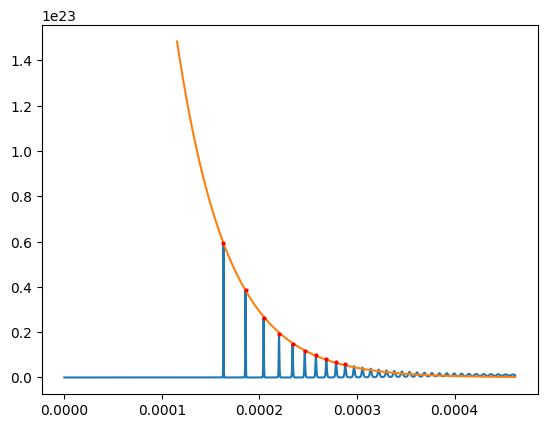

In [12]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

pind = find_peaks(sol[1], threshold  = 0.1 )
t_peak = t[pind[0]][:10]
y_peak = sol[1][pind[0]][:10]
plt.plot(t, sol[1])



p0 = [1e23,5000, 0]
popt, pcov = curve_fit(func, t_peak, y_peak, p0 = p0)
tt  = t[2500:]
plt.plot(tt, func(tt, *popt))
plt.plot(t_peak, y_peak , 'ro', ms = 2)
print(*popt)
tau_f = 1 / popt[1]

In [13]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def find_tau(t, sol_1):
    
    pind = find_peaks(sol_1, threshold  = 0.1 )
    t_peak = t[pind[0]][:10]
    y_peak = sol_1[pind[0]][:10]
    fig,ax = plt.subplots()
    plt.plot(t, sol_1)
    # matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    try:
        p0 = [1e23,5000, 0]
        popt, pcov = curve_fit(func, t_peak, y_peak, p0 = p0)

    except (ValueError, RuntimeError):  
        print('cant find fit')
        return 0  
    else:
        plt.plot(t_peak  , y_peak , 'ro', ms = 2)
        tau_f = 1 / popt[1]
        tt  = t[pind[0][0] - 50:]
        plt.plot(tt, func(tt, *popt))
        plt.gcf().text(0.2, .8, r"tau_f = " +'{:.2f}'.format(tau_f * 1e6) +' мкс ', fontsize = 10)
    return tau_f



tau_c = 27.699744785068102 нс
tau_c = 34.624680981335125 нс
tau_c = 41.54961717760215 нс
tau_c = 48.47455337386918 нс
tau_c = 55.399489570136204 нс
tau_c = 62.32442576640322 нс
tau_c = 69.24936196267025 нс
tau_c = 76.17429815893728 нс
tau_c = 83.0992343552043 нс


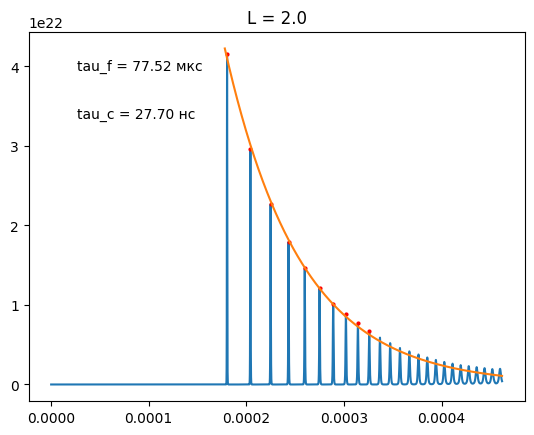

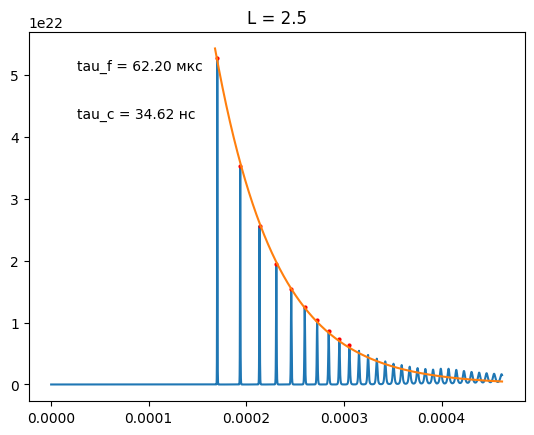

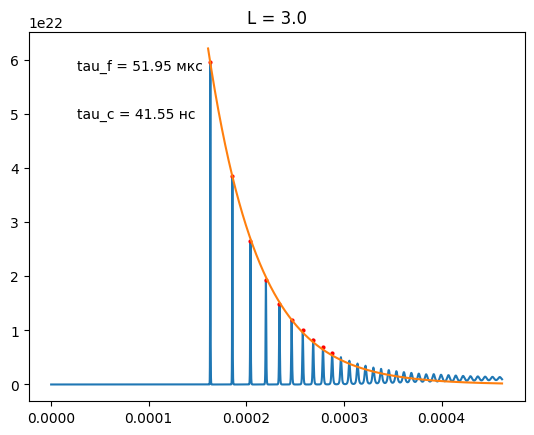

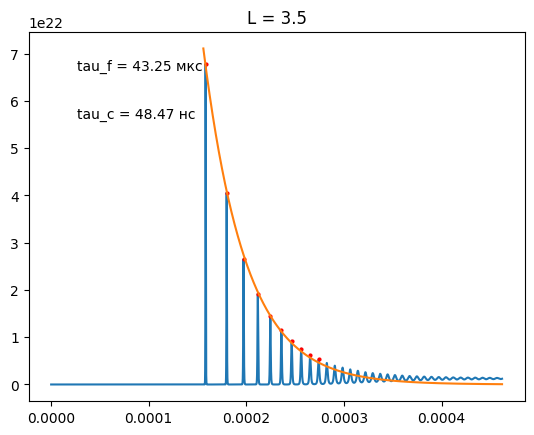

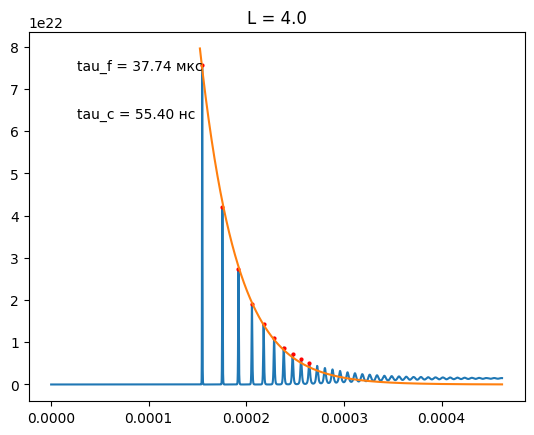

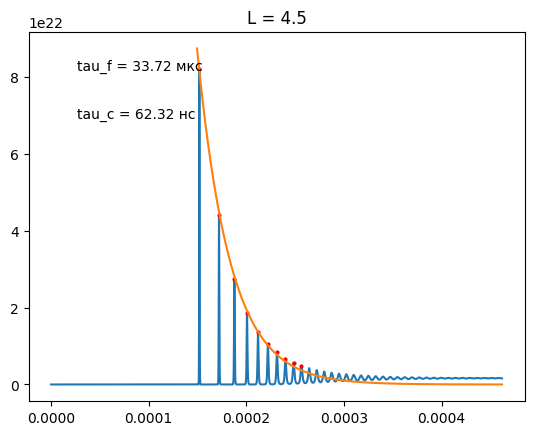

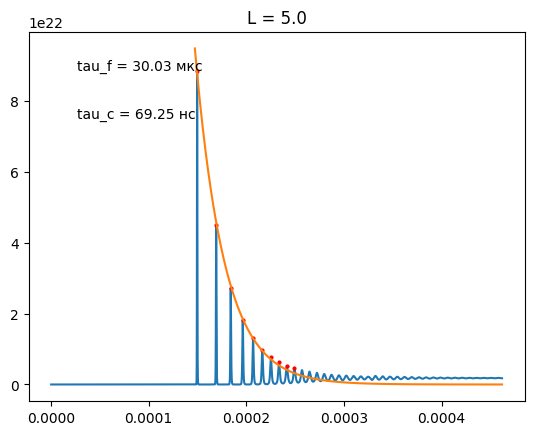

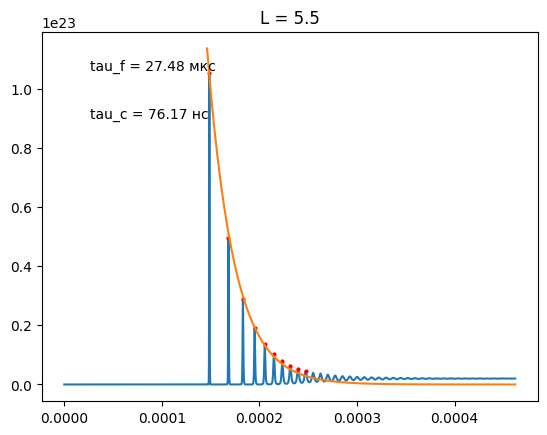

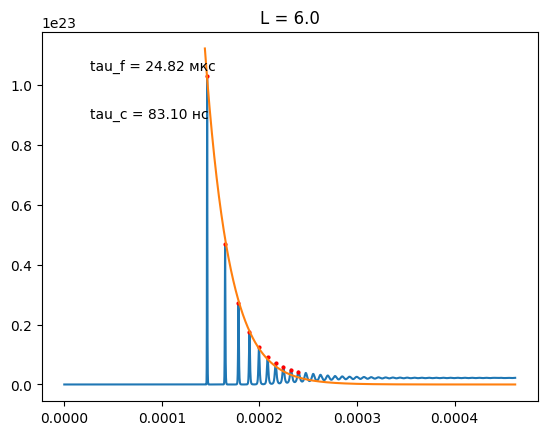

In [14]:
Ls = np.arange(2, 6.5, .5)
ltaus_f = []
ltaus_c = []





for l in Ls:
    tau_c = - 2 * l / (c * np.log(R1*R2))
    ltaus_c.append(tau_c)
    try:
        y =Yb(t, lmbda_p, lmbda_s,  s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c,  h, Aeffp, Aeffs,  Pp, N, l, R1, R2)
    except Exception as e:
        print(e.args, 'Well...')
    tau_f = find_tau(t, y[1])
    plt.gcf().text(0.2, .7, r"tau_c = " +'{:.2f}'.format(tau_c * 1e9) +' нс ', fontsize = 10)
    plt.title(f'L = {l}')
    ltaus_f.append(tau_f)

    
    


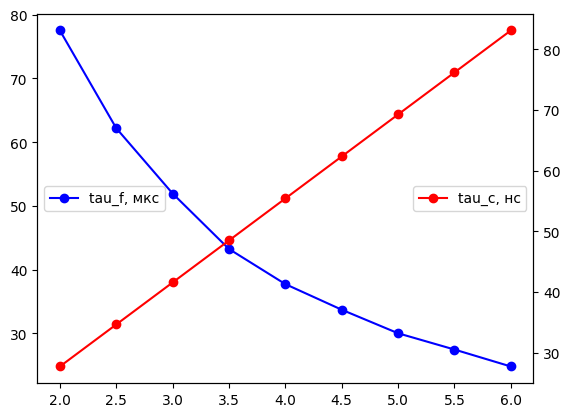

In [15]:
fig, ax = plt.subplots()
plt.plot(Ls, [t * 10**6 for t in ltaus_f] , 'bo-', label = 'tau_f, мкс')
ax1 = plt.twinx(ax)
ax1.plot(Ls, [t * 10**9 for t in ltaus_c] , 'ro-', label = 'tau_c, нс')
ax.legend(loc = 6)
ax1.legend(loc = 7)

tau_c = 12.507681078813654 нс
tau_c = 17.89444611531682 нс
tau_c = 23.920806098377078 нс
cant find fit
tau_c = 31.431072036593996 нс
tau_c = 41.54961717760215 нс
tau_c = 56.37931744237106 нс
tau_c = 80.74578965924535 нс
tau_c = 129.06489939046705 нс
tau_c = 273.3471815336612 нс
cant find fit


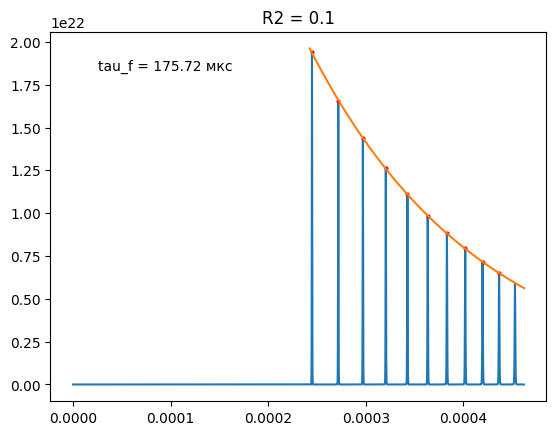

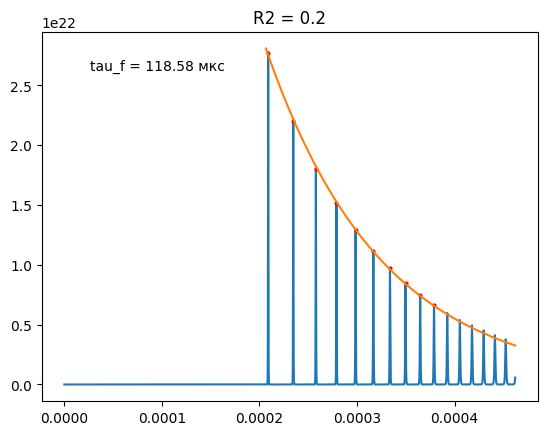

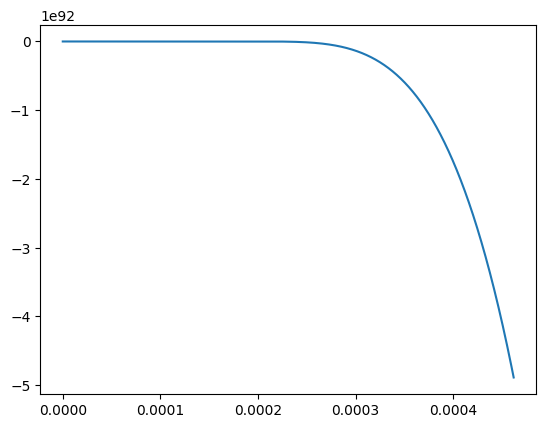

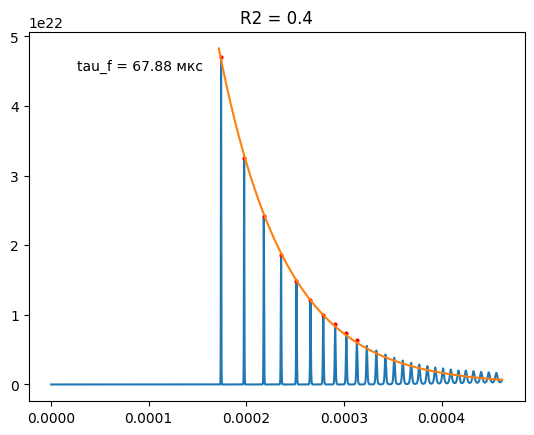

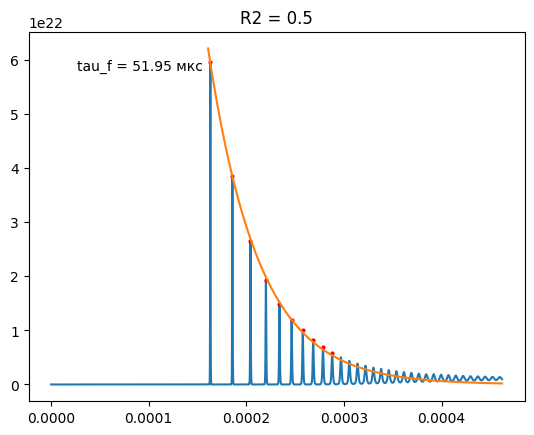

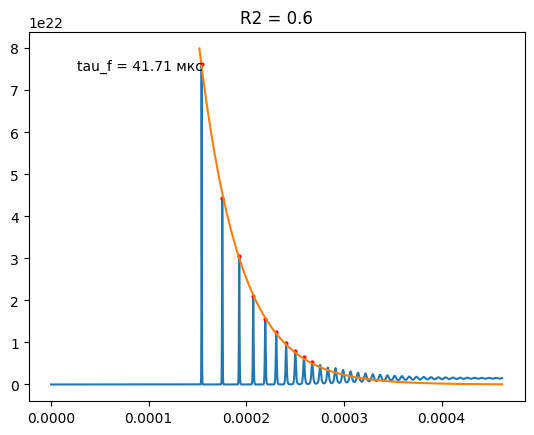

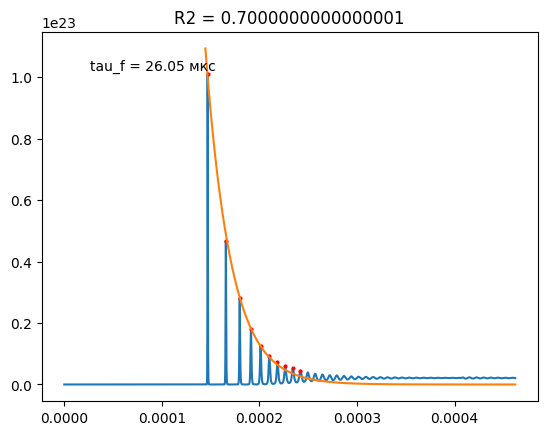

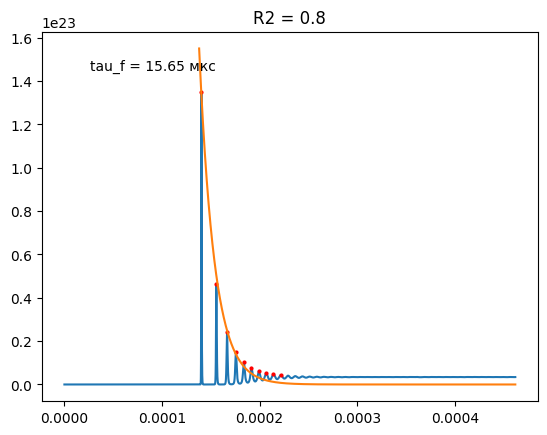

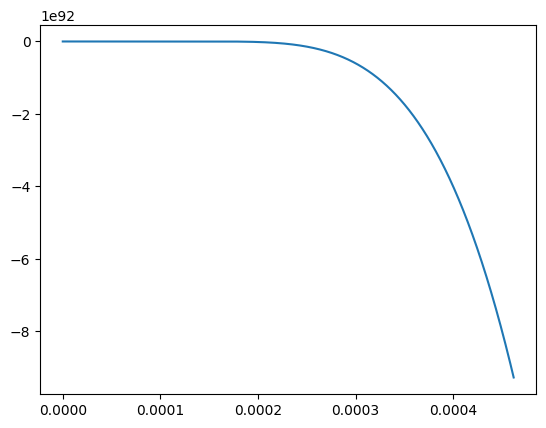

In [16]:
R2s = np.linspace(0.1, 0.9, 9, endpoint = True)
# R2s = np.arange(0.1, 1, 0.1)
rtaus_f = []
rtaus_c = []
for r2 in R2s:
    tau_c = - 2 * L / (c * np.log(R1*r2))
    rtaus_c.append(tau_c)
    sol = Yb(t, lmbda_p, lmbda_s,  s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c,  h, Aeffp, Aeffs,  Pp, N, L, R1, r2)
    
    
    tau_f = find_tau(t, sol[1])
    if tau_f !=0:
        plt.title(f'R2 = {r2}')
    rtaus_f.append(tau_f)


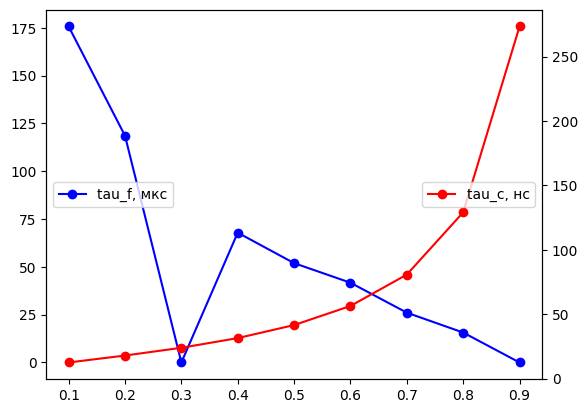

In [17]:
fig, ax = plt.subplots()
plt.plot(R2s, [t * 10**6 for t in rtaus_f] , 'bo-', label = 'tau_f, мкс')
ax1 = plt.twinx(ax)
ax1.plot(R2s, [t * 10**9 for t in rtaus_c] , 'ro-', label = 'tau_c, нс')
ax.legend(loc = 6)
ax1.legend(loc = 7)

Text(0, 0.5, 'tau, us')

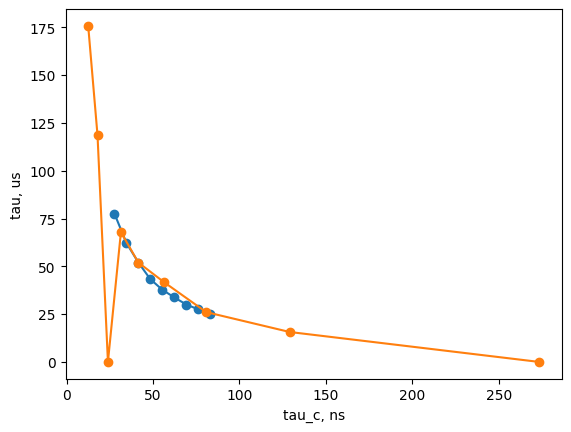

In [18]:
fig, ax = plt.subplots()
plt.plot(np.array(ltaus_c) * 1e9, np.array(ltaus_f) * 1e6, 'o-')
plt.plot(np.array(rtaus_c) * 1e9, np.array(rtaus_f) * 1e6, 'o-')
plt.xlabel('tau_c, ns')
plt.ylabel('tau, us')